In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Get the train and test data

In [2]:
from tensorflow.keras.utils import to_categorical

from utils.dataset import get_train_test_data

# get the train and test data in rgb format
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True, verbose=True)
# Turn the labels into one-bit-hot-encoding
train_labels_cat, test_labels_cat = to_categorical(train_labels), to_categorical(test_labels)

2022-04-12 23:54:36.915958: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train samples: 60000
Test samples: 10000
Data shape: (28, 28, 3)


# Train the classifier

In [5]:
from DigitClassifier import DigitClassifier

# Create an instance of the classifier and train it
classifier = DigitClassifier()
classifier.fit(train_data, train_labels, epochs=1)
loss, acc = classifier.evaluate(test_data, test_labels)
print(f'Accuracy on test: {acc}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0497 - sparse_categorical_accuracy: 0.9845
Accuracy on test: 0.984499990940094


/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/xplique/attributions/lime.py:188: UserWarning: You set a number of pertubed samples per input >= 500 and batch_size is set to NoneThis mean that you will ask your model to handle more than 500 pertubed samples per input at once.This can lead to OOM issue. To avoid it you can set the batch_size argument.
  warnings.warn(


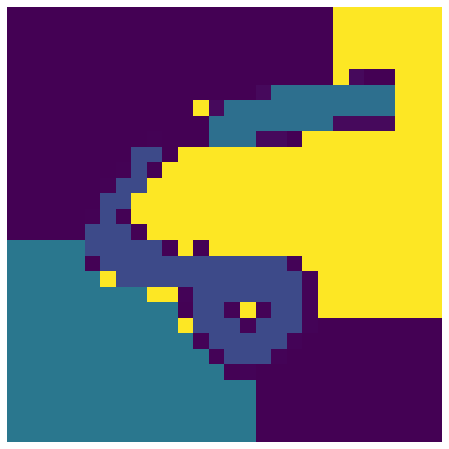

In [14]:
from xplique.attributions import SmoothGrad, GradCAMPP, Lime
from workflow.ClusteringMode import generate_contributions
import matplotlib.pyplot as plt
import numpy as np
from utils.general import save_figure

explainers = [
    (SmoothGrad(classifier, nb_samples=50, noise=.3, batch_size=64), 'smoothgrad'),
    (GradCAMPP(classifier), 'gradcampp'),
    (Lime(classifier, nb_samples=1000), 'lime')
]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for explainer, explainer_name in explainers:
    contributions = generate_contributions(explainer, test_data[test_labels == 5][:1], test_labels_cat[test_labels == 5][:1])
    ax.imshow(contributions)
    ax.axis('off')
    save_figure(fig, f'/Users/lodovicoazzini/Repos/USI-MSDE/III/Thesis_no_sync/weekly_meetings/2022-04-01_Update-Meeting/{explainer_name}')

# Generate the explanations

In [7]:
from xplique.attributions import IntegratedGradients

explainer = IntegratedGradients(classifier, steps=50)
explanations = explainer.explain(
    np.expand_dims(test_data[test_idx], 0),
    np.expand_dims(test_labels_cat[test_idx], 0)
).numpy()

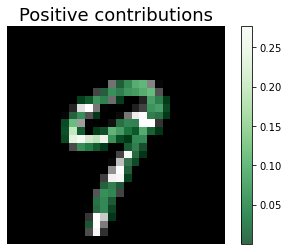

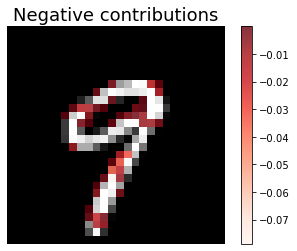

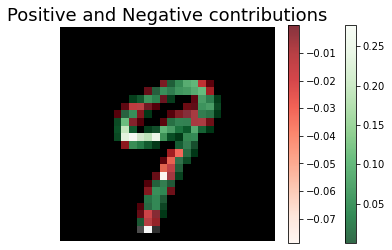

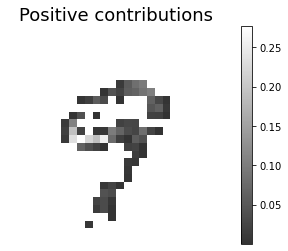

In [37]:
from utils.plotter import show_contributions, ContributionsMode

fig, ax = show_contributions(
    original=test_data[test_idx],
    mode=ContributionsMode.POSITIVE,
    contributions=explanations
)
fig, ax = show_contributions(
    original=test_data[test_idx],
    mode=ContributionsMode.NEGATIVE,
    contributions=explanations
)
fig, ax = show_contributions(
    original=test_data[test_idx],
    mode=ContributionsMode.ALL,
    contributions=explanations
)
fig, ax = show_contributions(
    mode=ContributionsMode.POSITIVE,
    contributions=explanations,
    cmap='gray'
)
# fig.savefig('../out/positive-contributions', dpi=300, transparent=True)

/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/xplique/attributions/lime.py:188: UserWarning: You set a number of pertubed samples per input >= 500 and batch_size is set to NoneThis mean that you will ask your model to handle more than 500 pertubed samples per input at once.This can lead to OOM issue. To avoid it you can set the batch_size argument.
  warnings.warn(


Method: DeconvNet


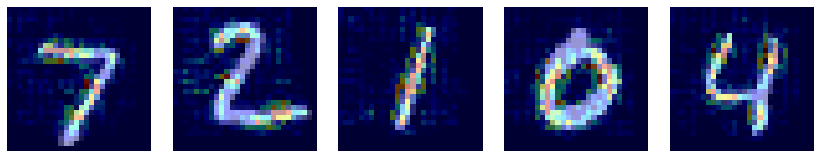


Method: Saliency


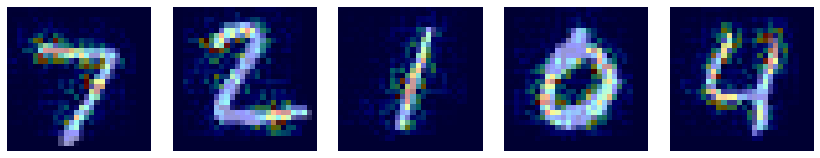


Method: GradientInput


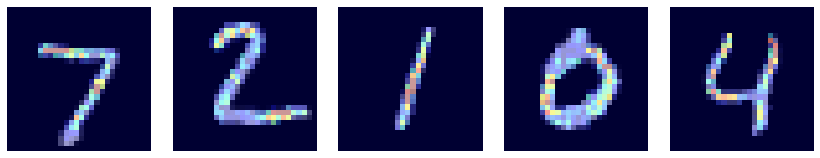


Method: GuidedBackprop


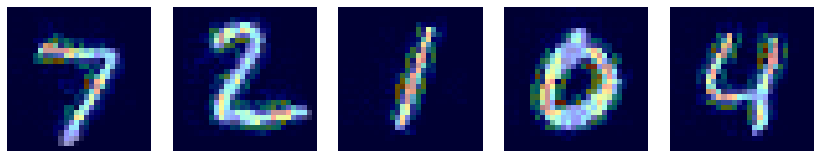


Method: IntegratedGradients


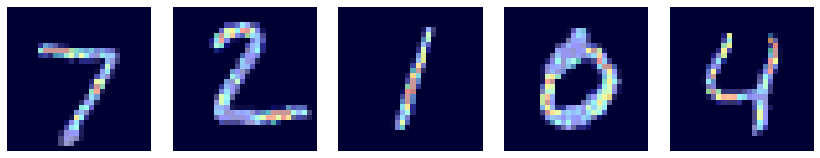


Method: SmoothGrad


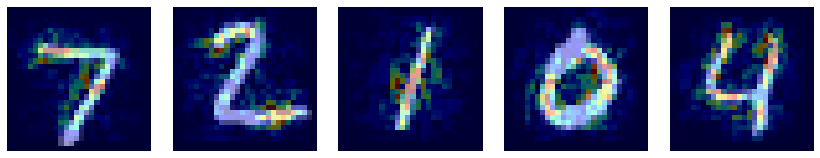


Method: SquareGrad


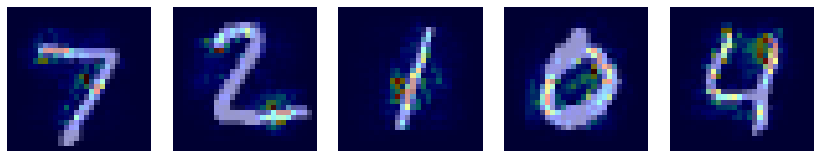


Method: VarGrad


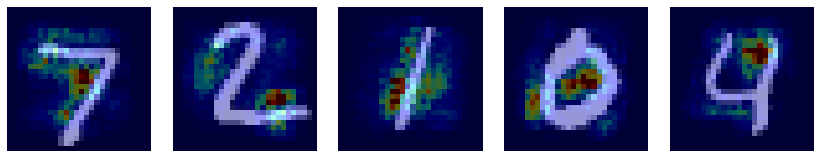


Method: GradCAM


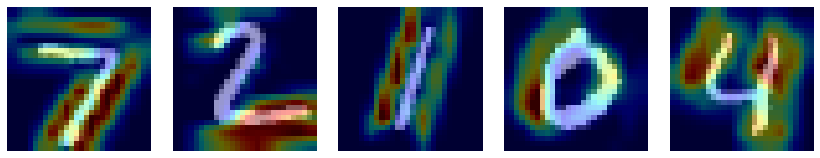


Method: GradCAMPP


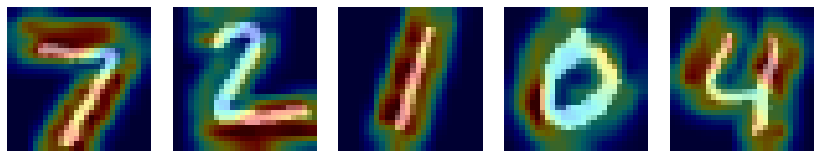


Method: Occlusion


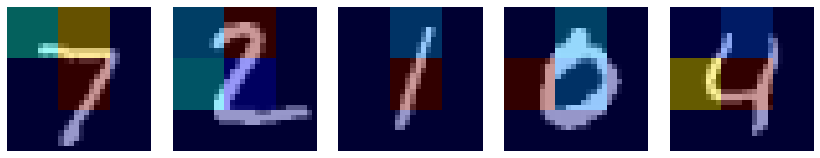


Method: Rise


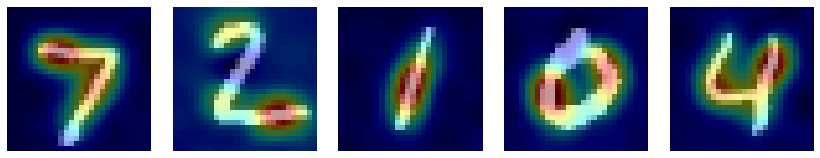


Method: Lime


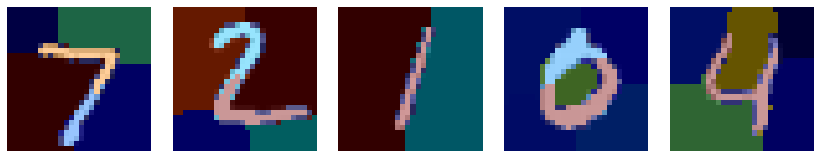


Method: KernelShap


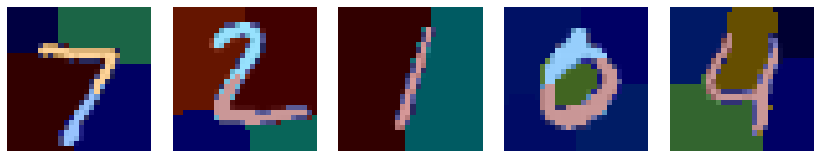

In [19]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, GradCAM, Occlusion, Rise, GuidedBackprop,
                                  GradCAMPP, Lime, KernelShap, DeconvNet)
from xplique.plots import plot_attributions
import matplotlib.pyplot as plt

# Generate the explanations
batch_size = 64
explainers = [
    DeconvNet(classifier),
    Saliency(classifier),
    GradientInput(classifier),
    GuidedBackprop(classifier),
    IntegratedGradients(classifier, steps=50, batch_size=batch_size),
    SmoothGrad(classifier, nb_samples=50, noise=.3, batch_size=batch_size),
    SquareGrad(classifier, nb_samples=50, batch_size=batch_size),
    VarGrad(classifier, nb_samples=50, batch_size=batch_size),
    GradCAM(classifier),
    GradCAMPP(classifier),
    Occlusion(classifier, patch_size=10, patch_stride=10, batch_size=batch_size),
    Rise(classifier, nb_samples=4000, batch_size=batch_size),
    Lime(classifier, nb_samples=1000),
    KernelShap(classifier, nb_samples=1000)
]

explanations_count = 5

# show the explanations
for row, explainer in enumerate(explainers):
    explainer_name = explainer.__class__.__name__
    #
    explanations = explainer(test_data[:explanations_count], test_labels_cat[:explanations_count]).numpy()

    if len(explanations.shape) > 3:
        explanations = np.mean(explanations, -1)

    print(f"Method: {explainer_name}")
    plot_attributions(explanations[:explanations_count], test_data[:explanations_count],
                      cmap='jet', alpha=0.4,
                      cols=explanations_count, clip_percentile=0.5, absolute_value=True)
    plt.show()
    print('')